In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

class Lumia():
    
    def __init__(self, dados={},heat_rate=[],pre_heat=False):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        self.data = dados
        self.pre_heat = pre_heat
        self.heat_rate = heat_rate
    #_______________________________________________________________________________________________________________

    def load_TL(self, arquivo,pre_heat=False, pre_heat_value=25, points_equal_temp=True,trimm_by='\t', lim_init = 4):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        with open(arquivo, 'r') as f:#Abre arquivo
            matrix = [[item for item in line.split(trimm_by)] for line in f.readlines()[lim_init:-1]]#Quebra linhas e colunas por tabulação
        matrixNumpy = np.array(matrix)                #matriz numpy
        curve={}                                     #variavel dicionario auxiliar
        for i in range(len(matrixNumpy.T)):       #É a iteração nas colunas pelo intervalo da matrix transposta do resultado
            lab=matrixNumpy[:,i]               #seleciona a coluna toda
            lista=[]                         #lista auxiliar
            for lin in lab:                   #iteração de valor em valor
                try:                         #evita bugs e erros por conversão falha
                    lista.append(int(lin))      #converte str para int
                except:
                    lista.append(np.nan)      #caso vazio e erro adiciona NAN
            if i == 0:                        #a primeira coluna é temperatura
                if pre_heat == False:          #Teste logico de preheat para soma de Temperatura inicial
                    curve.setdefault('Temperatura',lista) #Adciona o rótulo temperatura ao dicionario
                else:
                    lista = np.array(lista) + pre_heat_value #soma o preheat em um nd array
                    lista = list(lista)
                    curve.setdefault('Temperatura',lista) #adiciona a temperatura ao dicinario
            else:
                curve.setdefault('Curva {0}'.format(i),lista) #Adiciona as curvas ao dicionario
        data=pd.DataFrame(curve, index=curve['Temperatura']) #cria um pd.dataframe com os resultados
        self.data = data
        return data
    
        #_______________________________________________________________________________________________________________
    def add_data(self,arquivo):
        self.data = arquivo
        
         #______________________________________________________________________________________________________________
    def init_rise_prep(self,curva,lim_init=80,lim_fin=250,sig=0.07, npontos=13, pre_heat_val=25):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        pre_heat = self.pre_heat
    #variaveis importantes    
        k=0.00008617333262145                       #constante de bolzmann
                 #Diminuição do dataframe
        objeto = self.data[curva]
        curva1 = objeto[lim_init:lim_fin]            #Fatia o dataframe no intervalo de interesse
        limite = curva1.cumsum()                        #Determinação dos limites
        tol = limite[max(limite.index)]*sig            #Tolerância para seção do dataset
        atol = []                                     #lista vazia a ser preenchida com valores de intensidade TL
        index = []                                   #índice padrão
        temp = []                                  #temperatura em kelvin
    
        for it,num,cur in zip(limite,limite.index,curva1):
            if it < tol:
                atol.append(cur)
                temp.append(num+273)
                index.append(num)
        if pre_heat == True:
            temp = np.array(temp) + pre_heat_val
        else:
            pass 
        lim_temp = max(index)
        int_val = lim_temp - npontos #Seleciona 14 pontos
        diff = int_val-lim_init 
        Frame = pd.DataFrame()
        Frame['Temperatura (K)'] = temp
        Frame['TL'] = atol
        Frame['ln(TL)'] = np.log(atol)
        Frame['1/kt'] = 1/(k*Frame['Temperatura (K)'])
        Frame.index=index
        Frame= Frame[:][diff:]
        return Frame
    
        #_______________________________________________________________________________________________________________

    def init_rise_result(prepared_data):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        x = np.array(prepared_data['1/kt'])
        y = np.array(prepared_data['ln(TL)'])
        from scipy.stats import linregress
        lin_reg = linregress(x,y)
        ea = -1*lin_reg.slope
        answer = {'Parametros present':{'Energia de Ativação':'{0}  ± {1} eV'.format(ea, lin_reg.stderr),'r^2':lin_reg.rvalue},
                 'Parametros Calc':{'Energia de Ativação':ea,'incerteza':lin_reg.stderr}}
    
        answerdb = {'Energia de Ativação':ea,'incerteza':lin_reg.stderr, 'r^2':lin_reg.rvalue}
        return answerdb
    
        #_______________________________________________________________________________________________________________

    def extract_ir(self):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        resposta = {'EA_IR(eV)':[],'error_ir':[],'r^2_ir':[],'objeto':[]}#conjunto resposta
        colunas = list(self.data.columns)
        colunas = colunas[1:]
        objeto = self.data
        for coluna in colunas:
            
            dados = self.init_rise_prep(curva=coluna)                #função de preparação
            answer = Lumia.init_rise_result(dados)                    #função de regressão
            resposta['EA_IR(eV)'] += [answer['Energia de Ativação']]#adição da resposta
            resposta['error_ir'] += [answer['incerteza']]       #adição da resposta
            resposta['r^2_ir'] += [answer['r^2']]               #adição da resposta
            resposta['objeto'] += [coluna]                      #adição da resposta
        return pd.DataFrame(resposta,index=resposta['objeto'])
    
    #_______________________________________________________________________________________________________________
    def area_met_prep(self,curva,heat_rate, kin_order, lim_init=80,lim_fin=150,deltaT=1):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        objeto = self.data[curva]
        pre_heat= self.pre_heat
        if heat_rate > 6:
            lim_init=135 
            lim_fin=240 
        elif heat_rate ==6:
            lim_init=120
            lim_fin=220
        elif heat_rate == 5:
            lim_init=120
            lim_fin=220
        elif (heat_rate < 5) & (heat_rate>2):
            lim_init= 130
            lim_fin=  210
        elif heat_rate == 2:
            lim_init= 100
            lim_fin=  200
        elif heat_rate == 1:
            lim_init= 95
            lim_fin=  185
        elif heat_rate == 0.9:
            lim_init=95
            lim_fin= 190
        elif heat_rate == 0.8:
            lim_init=95
            lim_fin= 190
        elif heat_rate == 0.7:
            lim_init=90
            lim_fin=180
        elif (heat_rate < 0.7) & (heat_rate > 0.4):
            lim_init=90
            lim_fin=175
        elif (heat_rate == 0.4):
            lim_init=85
            lim_fin=170
        elif (heat_rate == 0.3):
            lim_init=85
            lim_fin=170
        
        elif (heat_rate == 0.2) | (heat_rate == 0.1):
            lim_init=80
            lim_fin=160
        k=0.00008617333262145
        y = np.array(objeto[lim_init:lim_fin])
        x = np.array(objeto[lim_init:lim_fin].index)
        temp = x+273     #converte a temperatura para kelvin
        preview = pd.DataFrame()
        if pre_heat == True:
            temp+=25
        else:
            pass
        preview['Temperatura (K)'] = temp
        preview['TL'] = y
        preview.set_index(x, inplace=True)
        area=[]
        for i in range(len(y)):
            area.append((max(y[i:len(y)].cumsum()))*(deltaT/heat_rate))
        np.array(area)
        preview['area'] = area
        preview['1/kt'] =  1/(k*preview['Temperatura (K)'])
        preview['ln(TL/area)'] = np.log(preview.TL/preview.area)
        preview['hr'] = [heat_rate]*len(area)
        for ko in kin_order:
            pr = np.array(np.log(preview.TL/(preview.area)**ko))
            preview = dict(preview)
            preview.setdefault('b= {0}'.format(ko), pr)
            preview = pd.DataFrame(preview)
            self.area_result = preview
        return preview
       #_______________________________________________________________________________________________________________

 
        #_______________________________________________________________________________________________________________
    def area_result(prepared_data, heat_rate):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        import math
        from scipy.stats import linregress
    
        x = np.array(prepared_data['1/kt'])
        atr_list = list(prepared_data.columns)
        atr_list = atr_list[4:]
        r_squared = {}
    
        for atributo in atr_list:
            y=np.array(prepared_data[atributo])
            lin_reg = linregress(x,y)
            r_squared.setdefault(atributo,-1*lin_reg.rvalue)
        best = max(r_squared)
        y=np.array(prepared_data[best])
        lin_reg = linregress(x,y)
        ea = -1*lin_reg.slope
        escape_factor = heat_rate*math.exp(-lin_reg.intercept)
        escape_error = lin_reg.intercept_stderr * escape_factor
        percentual_error = escape_error/escape_factor
        if best == 'ln(TL/area)':
            best = 'b = 1'
        answer_present = {'Energia de Ativação':'{0}  ± {1} eV'.format(ea, lin_reg.stderr),
                      'r^2':lin_reg.rvalue,
                      'Fator de Escape':'{0} ± {1} eV'.format(escape_factor,escape_error),
                      'Erro percentual':'{0} %'.format(percentual_error*100)}
        answer_db = {'Energia de Ativação':ea,
                 'Incerteza EA':lin_reg.stderr,
                 'r^2':lin_reg.rvalue,
                 'Fator de Escape':escape_factor, 
                 'Incerteza Escape_factor':escape_error,
                 'Percentual Error':percentual_error,
                 'Best_kin_order':best}                       
        return answer_present, answer_db
    
        #_______________________________________________________________________________________________________________


    def extract_area(self,heat_rate,test_kin_order):#informar uma lista com todas as taxas de aquecimento do DB
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        pre_heat = self.pre_heat
        resposta = {'EA_AREA(eV)':[],'error_AREA':[],'r^2_AREA':[],'freq_factor_AREA':[],
                    'ff_err_AREA':[],'ff_percerr_AREA':[],'AREA_kin_order':[],'objeto':[], 
                    'Taxa de aquecimento':[]} #conjunto resposta
        colunas = list(self.data.columns)
        colunas = colunas[1:]
        for coluna, hr in zip(colunas, heat_rate):
            dados = self.area_met_prep(coluna,hr, test_kin_order)                #função de preparação
            answer_pres, answer = Lumia.area_result(dados,hr)                    #função de regressão
            resposta['EA_AREA(eV)'] += [answer['Energia de Ativação']]#adição da resposta
            resposta['error_AREA'] += [answer['Incerteza EA']]       #adição da resposta
            resposta['r^2_AREA'] += [answer['r^2']]               #adição da resposta
            resposta['freq_factor_AREA'] += [answer['Fator de Escape']]
            resposta['ff_err_AREA'] += [answer['Incerteza Escape_factor']]
            resposta['ff_percerr_AREA'] += [answer['Percentual Error']]
            resposta['AREA_kin_order'] += [answer['Best_kin_order']]
            resposta['Taxa de aquecimento'] += [hr]
            resposta['objeto'] += [coluna]                      #adição da resposta
        return pd.DataFrame(resposta,index=resposta['objeto'])
    
    #_______________________________________________________________________________________________________________

    def peak_shape_met(curva,DeltaT=1,error=0.5, ph_val=25, pre_heat=False):
    #Encontrar a posição do pico
        peak = curva.max()

    #Encontrar o índice (Temperatura) do pico:

        j=0
        for i in curva:
            if i == peak:
                tmax = j*DeltaT
                break
            else:
                j+=1

    #Meia Altura
        half_peak = peak/2
    #Divisão do Dataset em dois
        t1_cand = np.array(curva[:tmax]) #Para T1
        t2_cand = np.array(curva[tmax:]) #Para T2

    #################################################################################################################

    #Testes lógicos para encontrar os índex respectivos
    # Fração inferior ao pico
        j=0
        for cand1 in t1_cand:
            if cand1 < half_peak:
                j0=j
                j+=1
            else:
                j2 = j0+1
                j+= 1
                continue
    # O j não reseta entre as iterações de t1_cand para t2_cand

    # Fração superior ao pico
        for cand2 in t2_cand:
            if cand2 > half_peak:
                j1=j
                j+=1
            else:
                j3 = j1+1
                break

    #Obtenção de T1 e transformação de ponto para temperatura
        if (half_peak - curva[j0]) < (curva[j2] - half_peak):
            t1 = j0 * DeltaT
        else:
            t1 = j2 * DeltaT
    #Obtenção de T2  
        if (curva[j1] - half_peak) < (half_peak - curva[j3]):
            t2 = j1 * DeltaT
        else:
            t2 = j3 * DeltaT
    ########################################################################################################################    

    # para kelvin
        t1 += 273
        t2 += 273
        tmax += 273
        k=0.00008617333262145
        
        if pre_heat == True:
            t1 += ph_val
            t2 += ph_val
            tmax += ph_val
        else:
            pass
    # Calculo dos parâmetros de forma
        delta = t2 - tmax
        omega = t2 - t1
        tau = tmax - t1
        shape_factor_mi = delta/omega
        shape_factor_gama = delta/tau

    #Energia de ativação

    #Omega de Chen
        omega_chen = (2.25+10.2*(shape_factor_mi - 0.42))*((k*tmax**2)/omega) - 1*(2*k*tmax)
    #Tau de Chen
        tau_chen = (1.510+3.0*(shape_factor_mi - 0.42))*((k*tmax**2)/tau) - (1.58+4.2*(shape_factor_mi - 0.42))*(2*k*tmax)
    #delta de Chen
        delta_chen = (0.976+7.3*(shape_factor_mi - 0.42))*((k*tmax**2)/delta)
    #kinetic order
        if shape_factor_mi < 0.44:
            kin_order = 'Primeira Ordem'
        elif shape_factor_mi < 0.50:
            kin_order = 'Ordem Geral'
        else:
            kin_order = 'Segunda Ordem'
    #Incertezas
    #delta
        delta_error = (2*(error/tmax) + (error/delta))*delta_chen
        mi_error = ((error/delta) + (error/omega))*shape_factor_mi
    #resposta
        answer = {'Parâmetros de forma':{'delta':'{0} K'.format(delta),'omega':'{0} K'.format(omega),'tau':'{0} K'.format(tau),
                                         'mi':'{0} ± {1}'.format(shape_factor_mi, mi_error)},
                  'Energia de Ativação':{'Delta de Chen':'{0} ± {1} eV'.format(delta_chen,delta_error),
                                         'Tau de Chen':'{0} eV'.format(tau_chen),
                                         'Omega de Chen':'{0} eV'.format(omega_chen)},
                  'Ordem Cinética':kin_order, 'Outras informações':{'TMax':'{0} K'.format(tmax),'T1':'{0} K'.format(t1),
                                                                'T2':'{0} K'.format(t2), 'IM':peak}}
        answerdb = {'Delta de Chen':delta_chen,
                    'deta_error':delta_error,
                    'Tau de Chen':tau_chen,
                    'Omega de Chen':omega_chen,
                    'Ordem Cinética':kin_order,
                    'Tmax':tmax,
                    'T1':t1,
                    'T2':t2,
                    'IM':peak,
                    'Mi':shape_factor_mi,
                    'mi_error':mi_error,
                    'delta':delta,
                    'Tau':tau,
                    'Omega':omega}
        return answer, answerdb
    
    #_______________________________________________________________________________________________________________
    def extract_pshape(self):
        pre_heat = self.pre_heat
        resposta = {'tau_chen(eV)':[],'omega_chen(eV)':[],'delta_chen(eV)':[],'delta_error':[],
                    'ordem_cinetica':[],'tmax':[],'t1':[],'t2':[],'IM':[],'Shape_factor':[],
                    'Sf_error':[],'objeto':[]} #conjunto resposta
        colunas = list(self.data.columns)
        colunas = colunas[1:]
        for coluna in colunas:              
            answer_pres, answer = Lumia.peak_shape_met(self.data[coluna],pre_heat=pre_heat)                    #função de regressão
            resposta['tau_chen(eV)'] += [answer['Tau de Chen']]#adição da resposta
            resposta['omega_chen(eV)'] += [answer['Omega de Chen']]       #adição da resposta
            resposta['delta_chen(eV)'] += [answer['Delta de Chen']]               #adição da resposta
            resposta['delta_error'] += [answer['deta_error']]       
            resposta['ordem_cinetica'] += [answer['Ordem Cinética']]          
            resposta['tmax'] += [answer['Tmax']]          
            resposta['t1'] += [answer['T1']]          
            resposta['t2'] += [answer['T2']]
            resposta['IM'] += [answer['IM']]
            resposta['Shape_factor'] += [answer['Mi']]
            resposta['Sf_error'] += [answer['mi_error']]
            resposta['objeto'] += [coluna]                      #adição da resposta
        return pd.DataFrame(resposta,index=resposta['objeto'])
    
     #_______________________________________________________________________________________________________________
    
    def multi_heating_rate_ti(curva1,curva2,heating_rate, DeltaT=1):
        pre_heat = self.pre_heat
    #Encontrar a posição do pico
        if pre_heat == True:
            pre_heat_temp=25
        else:
            pre_heat_temp=0
        k=0.00008617333262145
        curvas = [curva1,curva2] #transforma em um objeto tipo lista iteravel
        ind=0 # quando ind=0, sub index 1, quando ind=1 sub index 2
#Encontrar IM & TM de cada uma das curvas:
        for curva, hr in zip(curvas, heating_rate):
            peak = curva.max()
            j=0
            for i in curva:
                if i == peak:
                    tmax = j*DeltaT + pre_heat_temp
                    break
                else:
                    j+=1
            if ind == 0:
                tm1c = tmax
                Im1s = peak
                hr_1 = hr
                Im1 = peak/hr_1
                Tm1 = tm1c+ 273
             
            else:
                tm2c = tmax
                hr_2= hr
                Im2 = peak/hr_2
                Tm2 = tm2c + 273
            ind+=1
    #Calculo da Energia de ativação
        EA_beta = k * ((Tm1*Tm2)/(Tm1-Tm2))*np.log((hr_1/hr_2)*(Tm1/Tm2)**2)
        EA_Im = ((k*Tm1*Tm2)/(Tm1-Tm2))*np.log((Im1/Im2))
        return(EA_beta,EA_Im,Tm1,Tm2)

    #_______________________________________________________________________________________________________________
    def multi_heating_rate_prep(dataset,curvas,heating_rate, DeltaT=1,ph_val=25, pre_heat=False): 
        Df_new = {'Temperatura (C)':[], 'Temperatura (K)':[],'y':[],'x':[],'Heat_rate':[]}
        k=0.00008617333262145
        for curv, hr in zip(curvas, heating_rate):
            curva = dataset[curv]
            peak = curva.max()
            j=0
            for i in curva:
                if i == peak:
                    tmax = j*DeltaT
                    break
                else:
                    j+=1
            if pre_heat==True:
                tm1c = tmax+ph_val
            else:
                tm1c = tmax
            Tm = tm1c+ 273
            
            Df_new['Temperatura (C)'] += [tm1c]
            Df_new['Temperatura (K)'] += [Tm]
            Df_new['y'] += [np.log((Tm**2)/hr)]
            Df_new['x'] += [1/(k*Tm)]
            Df_new['Heat_rate'] += [hr]
        return pd.DataFrame(Df_new)

    #_______________________________________________________________________________________________________________
    def multi_heating_rate_reg(dados_preparados):#recebe a saída de multi_heating_rate_prep()
        from scipy.stats import linregress
        import math
        k=0.00008617333262145
        x = dados_preparados['x']
        y = dados_preparados['y']
    #Regressão Linear

        lin_reg = linregress(x,y) #Regressão
    
    #Calculo de parâmetros cinéticos

        ea = lin_reg.slope
        intercept = lin_reg.intercept
        escape_factor = ea*math.exp(intercept/k)
        escape_per_error = (lin_reg.stderr/ea) + lin_reg.intercept_stderr
        escape_error = escape_per_error * escape_factor
    
    #Resposta   
        answer_present = {'Energia de Ativação':'{0}  ± {1} eV'.format(ea, lin_reg.stderr),
                            'r^2':lin_reg.rvalue,
                          'Fator de Escape':'{0} ± {1} eV'.format(escape_factor,escape_error),
                          'Erro percentual':'{0} %'.format(escape_per_error*100)}
        answer_db = {'Energia de Ativação':ea,
                     'Incerteza EA':lin_reg.stderr,
                     'r^2':lin_reg.rvalue,
                     'Fator de Escape':escape_factor, 
                     'Incerteza Escape_factor':escape_error,
                     'Percentual Error':escape_per_error} 
        return answer_present, answer_db
    #_______________________________________________________________________________________________________________

#Entra com o conjunto de dados e uma lista com a lista de nomes das curvas de cada amostra
    def extract_mhr(self,samples,heat_rate):#informar uma lista com todas as taxas de aquecimento do DB
        resposta = {'EA_mhr(eV)':[],'error_mhr':[],'r^2_mp':[],'freq_factor_mp':[],
                    'ff_percerr_mp':[],'Amostra':[] 
                    } #conjunto resposta
        amostra = 1
        pre_heat = self.pre_heat
        for sample in samples:
        
            dados = Lumia.multi_heating_rate_prep(self.data,sample,heat_rate,pre_heat=pre_heat)               #função de preparação
            answer_pres, answer = multi_heating_rate_reg(dados)                    #função de regressão
            resposta['EA_mhr(eV)'] += [answer['Energia de Ativação']]#adição da resposta
            resposta['error_mhr'] += [answer['Incerteza EA']]       #adição da resposta
            resposta['r^2_mp'] += [answer['r^2']]               #adição da resposta
            resposta['freq_factor_mp'] += [answer['Fator de Escape']]
            resposta['ff_percerr_mp'] += [answer['Percentual Error']]
            resposta['Amostra'] += ['Amosta {0}'.format(amostra)]                      #adição da resposta
            amostra+=1
        return pd.DataFrame(resposta, index=resposta['Amostra'])

# doses001.txt

In [25]:
arquivo = Lumia(pre_heat=True)

In [26]:
arquivo.load_TL('C:/Users/André Tavares/Desktop/MESTRADO - CDTN/Ensaio Luiz/doses001.txt', lim_init=2)

,Temperatura,Curva 1,Curva 2,Curva 3,Curva 4,Curva 5,Curva 6,Curva 7,Curva 8,Curva 9,...,Curva 39,Curva 40,Curva 41,Curva 42,Curva 43,Curva 44,Curva 45,Curva 46,Curva 47,Curva 48
0,0,2,7,12,19846,8,10,33878,4,23,...,127,113235,24,126,119685,30,147,122665,30,144
1,1,5,9,10,19701,7,15,33498,11,19,...,112,112643,28,158,119279,32,144,122291,18,152
2,2,9,9,12,19579,8,14,33492,7,25,...,120,112373,15,140,118590,19,144,121672,31,182
3,3,4,7,4,19503,4,12,33133,6,31,...,106,112588,23,131,119551,25,151,121933,23,144
4,4,5,3,13,19747,10,14,33300,10,27,...,121,112247,20,127,118874,22,128,120996,23,153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,521,1810656,1470504,1716411,1784002,1427165,1677224,1768895,1447462,1716913,...,1775235,1764496,1491285,1739466,1789159,1458880,1747473,1775445,1543662,1709998
522,522,1863922,1528578,1811509,1831393,1478671,1741097,1814208,1497033,1825991,...,1822795,1821501,1512186,1800279,1864780,1501509,1780137,1830586,1551265,1767945
523,523,1920810,1555371,1866272,1889237,1545718,1830779,1905793,1574421,1897581,...,1839555,1886701,1522510,1857425,1962234,1555686,1794002,1900626,1587033,1801938
524,524,1971811,1576463,1882036,1950517,1617963,1886751,1948496,1670116,1931463,...,1891766,1960897,1569693,1878226,2006332,1595640,1857319,1961878,1657994,1854801


In [27]:
arquivo.data = arquivo.data[:][:350]
heat_rate = [5]*48
detector = ['ChNum','TLD-500','ALOX-520']*16
timee = [0]*3+[1]*3+[2]*3+[3]*3+[4]*3+[5]*3+[6]*3+[7]*3+[8]*3+[9]*3+[10]*3+[11]*3+[12]*3+[13]*3+[14]*3+[15]*3
len(timee)

48

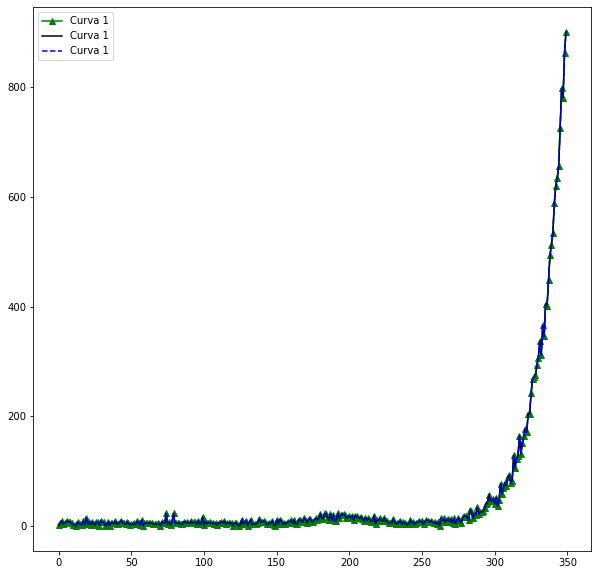

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
i = [1,1,1]
cor = ['^g-','k-','b--']
Fig1=plt.Figure(figsize=(10,10)); ax = Fig1.add_subplot(1,1,1)
for isa,color in zip(i,cor):
    ax.plot(arquivo.data['Temperatura'], arquivo.data['Curva {0}'.format(isa)], color, label= 'Curva {0}'.format(isa))
ax.legend(loc='best')
Fig1

In [29]:
ir = arquivo.extract_ir()
ir['detector'] = detector
ir['IRR_TIME'] = timee
ir

,EA_IR(eV),error_ir,r^2_ir,objeto,detector,IRR_TIME
Curva 1,0.053220,0.371780,-0.041288,Curva 1,ChNum,0
Curva 2,1.566848,0.007019,-0.999880,Curva 2,TLD-500,0
Curva 3,1.614924,0.004494,-0.999954,Curva 3,ALOX-520,0
Curva 4,1.364647,0.010168,-0.999667,Curva 4,ChNum,1
Curva 5,1.570848,0.011401,-0.999684,Curva 5,TLD-500,1
Curva 6,1.631869,0.007340,-0.999879,Curva 6,ALOX-520,1
Curva 7,1.351677,0.013240,-0.999425,Curva 7,ChNum,2
Curva 8,1.583579,0.009848,-0.999768,Curva 8,TLD-500,2
Curva 9,1.617802,0.005503,-0.999931,Curva 9,ALOX-520,2
Curva 10,1.343691,0.011838,-0.999535,Curva 10,ChNum,3


In [30]:
area = arquivo.extract_area(heat_rate,[1.1,1.2,1.3])
area['detector'] = detector
area['IRR_TIME'] = timee
area

c:\users\andré tavares\appdata\local\programs\python\python38\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\andré tavares\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2474: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


,EA_AREA(eV),error_AREA,r^2_AREA,freq_factor_AREA,ff_err_AREA,ff_percerr_AREA,AREA_kin_order,objeto,Taxa de aquecimento,detector,IRR_TIME
Curva 1,NaN,NaN,NaN,NaN,NaN,NaN,b = 1,Curva 1,5,ChNum,0
Curva 2,1.584770,0.027999,-0.985048,2.890020e-15,2.020137e-15,0.699004,b = 1,Curva 2,5,TLD-500,0
Curva 3,1.346251,0.035272,-0.967971,5.274025e-13,4.644247e-13,0.880589,b = 1,Curva 3,5,ALOX-520,0
Curva 4,1.366148,0.015656,-0.993626,1.927787e-13,7.534958e-14,0.390861,b = 1,Curva 4,5,ChNum,1
Curva 5,1.649064,0.025864,-0.988160,6.382399e-16,4.121147e-16,0.645705,b = 1,Curva 5,5,TLD-500,1
Curva 6,1.347332,0.036419,-0.966013,5.218499e-13,4.744797e-13,0.909226,b = 1,Curva 6,5,ALOX-520,1
Curva 7,1.346276,0.016244,-0.992942,3.046279e-13,1.235375e-13,0.405536,b = 1,Curva 7,5,ChNum,2
Curva 8,1.670354,0.024617,-0.989525,3.824525e-16,2.350450e-16,0.614573,b = 1,Curva 8,5,TLD-500,2
Curva 9,1.340608,0.036120,-0.966221,6.106266e-13,5.506439e-13,0.901769,b = 1,Curva 9,5,ALOX-520,2
Curva 10,1.323789,0.016610,-0.992374,5.144920e-13,2.133448e-13,0.414671,b = 1,Curva 10,5,ChNum,3


In [31]:
arquivo.data.pop('Curva 1')

0        2
1        5
2        9
3        4
4        5
      ... 
345    725
346    798
347    781
348    862
349    901
Name: Curva 1, Length: 350, dtype: int64

In [32]:
import numpy as np
import pandas as pd
detector.pop(0)
timee.pop(0)
chen = arquivo.extract_pshape()
chen['detector'] = detector
chen['IRR_TIME'] = timee
chen

,tau_chen(eV),omega_chen(eV),delta_chen(eV),delta_error,ordem_cinetica,tmax,t1,t2,IM,Shape_factor,Sf_error,objeto,detector,IRR_TIME
Curva 2,1.647349,1.490343,1.642753,0.051445,Ordem Geral,525,504,542,248235,0.447368,0.019044,Curva 2,TLD-500,0
Curva 3,1.457298,1.244473,1.338857,0.054135,Primeira Ordem,507,487,520,938734,0.393939,0.021120,Curva 3,ALOX-520,0
Curva 4,1.092353,1.008788,1.134549,0.025919,Ordem Geral,497,469,521,991327,0.461538,0.014053,Curva 4,ChNum,1
Curva 5,1.647349,1.490343,1.642753,0.051445,Ordem Geral,525,504,542,228840,0.447368,0.019044,Curva 5,TLD-500,1
Curva 6,1.628903,1.446052,1.586947,0.059813,Primeira Ordem,506,487,520,517592,0.424242,0.021579,Curva 6,ALOX-520,1
Curva 7,1.052128,0.973981,1.098021,0.024170,Ordem Geral,497,468,522,1788091,0.462963,0.013546,Curva 7,ChNum,2
Curva 8,1.647349,1.490343,1.642753,0.051445,Ordem Geral,525,504,542,430585,0.447368,0.019044,Curva 8,TLD-500,2
Curva 9,1.509983,1.323755,1.449107,0.054612,Primeira Ordem,507,487,521,905321,0.411765,0.020761,Curva 9,ALOX-520,2
Curva 10,1.065504,0.989094,1.109665,0.023577,Ordem Geral,496,467,522,2485128,0.472727,0.013388,Curva 10,ChNum,3
Curva 11,1.647349,1.490343,1.642753,0.051445,Ordem Geral,525,504,542,631173,0.447368,0.019044,Curva 11,TLD-500,3


In [81]:
chen

,tau_chen(eV),omega_chen(eV),delta_chen(eV),delta_error,ordem_cinetica,tmax,t1,t2,IM,Shape_factor,Sf_error,objeto,detector,IRR_TIME
Curva 2,1.647349,1.490343,1.642753,0.051445,Ordem Geral,525,504,542,248235,0.447368,0.019044,Curva 2,TLD-500,0
Curva 3,1.457298,1.244473,1.338857,0.054135,Primeira Ordem,507,487,520,938734,0.393939,0.021120,Curva 3,ALOX-520,0
Curva 4,1.092353,1.008788,1.134549,0.025919,Ordem Geral,497,469,521,991327,0.461538,0.014053,Curva 4,ChNum,1
Curva 5,1.647349,1.490343,1.642753,0.051445,Ordem Geral,525,504,542,228840,0.447368,0.019044,Curva 5,TLD-500,1
Curva 6,1.628903,1.446052,1.586947,0.059813,Primeira Ordem,506,487,520,517592,0.424242,0.021579,Curva 6,ALOX-520,1
Curva 7,1.052128,0.973981,1.098021,0.024170,Ordem Geral,497,468,522,1788091,0.462963,0.013546,Curva 7,ChNum,2
Curva 8,1.647349,1.490343,1.642753,0.051445,Ordem Geral,525,504,542,430585,0.447368,0.019044,Curva 8,TLD-500,2
Curva 9,1.509983,1.323755,1.449107,0.054612,Primeira Ordem,507,487,521,905321,0.411765,0.020761,Curva 9,ALOX-520,2
Curva 10,1.065504,0.989094,1.109665,0.023577,Ordem Geral,496,467,522,2485128,0.472727,0.013388,Curva 10,ChNum,3
Curva 11,1.647349,1.490343,1.642753,0.051445,Ordem Geral,525,504,542,631173,0.447368,0.019044,Curva 11,TLD-500,3


# doses002.txt

In [16]:
arquivo2=Lumia(pre_heat=True)

In [17]:
arquivo2.load_TL('C:/Users/André Tavares/Desktop/MESTRADO - CDTN/Ensaio Luiz/doses002.txt', lim_init=2)

,Temperatura,Curva 1,Curva 2,Curva 3,Curva 4,Curva 5,Curva 6,Curva 7,Curva 8,Curva 9,Curva 10
0,0,21198,44,67578,33,129937,44,227277,146,351289,310
1,1,21080,32,66680,13,127419,43,225349,130,347800,255
2,2,21329,58,65610,23,125847,62,221956,138,343521,280
3,3,21893,30,64507,19,123933,55,219403,141,339859,258
4,4,22641,46,63165,20,121819,40,216461,148,336217,269
...,...,...,...,...,...,...,...,...,...,...,...
521,521,4137003,3721988,3989510,3704540,4004074,3726508,3965718,3790296,3940630,3656604
522,522,4286056,3768397,4035174,3696832,4152553,3768161,4122470,3855939,4078225,3755912
523,523,4334265,3895643,4168490,3830597,4273427,3899333,4245312,4014241,4209079,3946018
524,524,4580907,4051874,4341154,3955907,4373631,4024929,4287015,4098486,4304733,3995886


In [19]:
arquivo2.data = arquivo2.data[:][:350]

In [21]:
heat_rate = [2]*10
detector = ['TLD-500','ALOX-520']*5
time = [1,1,2,2,4,4,8,8,15,15]


In [22]:
area2 = arquivo2.extract_area(heat_rate,[1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0])
area2['detector'] = detector
area2['IRR_TIME'] = time
area2

,EA_AREA(eV),error_AREA,r^2_AREA,freq_factor_AREA,ff_err_AREA,ff_percerr_AREA,AREA_kin_order,objeto,Taxa de aquecimento,detector,IRR_TIME
Curva 1,1.055772,0.014011,-0.991480,7.325933e-11,2.678525e-11,0.365622,b = 1,Curva 1,2,TLD-500,1
Curva 2,1.301726,0.011914,-0.995920,1.631308e-13,5.071926e-14,0.310912,b = 1,Curva 2,2,ALOX-520,1
Curva 3,1.039178,0.014178,-0.991001,1.107664e-10,4.098215e-11,0.369987,b = 1,Curva 3,2,TLD-500,2
Curva 4,1.322345,0.010800,-0.996747,9.880786e-14,2.784798e-14,0.281840,b = 1,Curva 4,2,ALOX-520,2
Curva 5,1.016482,0.014507,-0.990167,1.969692e-10,7.456540e-11,0.378564,b = 1,Curva 5,2,TLD-500,4
Curva 6,1.313358,0.010948,-0.996612,1.226870e-13,3.505104e-14,0.285695,b = 1,Curva 6,2,ALOX-520,4
Curva 7,0.973953,0.015269,-0.988170,5.761755e-10,2.295750e-10,0.398446,b = 1,Curva 7,2,TLD-500,8
Curva 8,1.300748,0.011038,-0.996490,1.675651e-13,4.826592e-14,0.288043,b = 1,Curva 8,2,ALOX-520,8
Curva 9,0.913748,0.016693,-0.984037,2.643033e-09,1.151323e-09,0.435607,b = 1,Curva 9,2,TLD-500,15
Curva 10,1.281111,0.011039,-0.996382,2.739026e-13,7.890122e-14,0.288063,b = 1,Curva 10,2,ALOX-520,15


In [23]:
chen2 = arquivo2.extract_pshape()
chen2['detector'] = detector
chen2['IRR_TIME']  = time
chen2

,tau_chen(eV),omega_chen(eV),delta_chen(eV),delta_error,ordem_cinetica,tmax,t1,t2,IM,Shape_factor,Sf_error,objeto,detector,IRR_TIME
Curva 1,1.054551,0.977592,1.088361,0.025025,Ordem Geral,463,437,487,1971732,0.480000,0.014800,Curva 1,TLD-500,1
Curva 2,1.348202,1.174014,1.282163,0.052042,Primeira Ordem,470,451,483,448191,0.406250,0.021973,Curva 2,ALOX-520,1
Curva 3,0.993915,0.922086,1.035478,0.023809,Ordem Geral,463,436,487,3523070,0.470588,0.014418,Curva 3,TLD-500,2
Curva 4,1.396160,1.241846,1.369169,0.051812,Primeira Ordem,470,451,484,923839,0.424242,0.021579,Curva 4,ALOX-520,2
Curva 5,1.039591,0.964700,1.062717,0.021980,Segunda Ordem,462,435,489,6128989,0.500000,0.013889,Curva 5,TLD-500,4
Curva 6,1.288497,1.131682,1.245318,0.047125,Primeira Ordem,470,450,484,1766611,0.411765,0.020761,Curva 6,ALOX-520,4
Curva 7,0.898624,0.840707,0.946167,0.018939,Ordem Geral,463,433,491,9664784,0.482759,0.012782,Curva 7,TLD-500,8
Curva 8,1.288497,1.131682,1.245318,0.047125,Primeira Ordem,470,450,484,3189007,0.411765,0.020761,Curva 8,ALOX-520,8
Curva 9,0.736407,0.695006,0.801233,0.014650,Ordem Geral,464,429,495,12874154,0.469697,0.011134,Curva 9,TLD-500,15
Curva 10,1.364575,1.235122,1.367639,0.045655,Ordem Geral,469,449,485,5205012,0.444444,0.020062,Curva 10,ALOX-520,15


In [62]:
ir2 = arquivo2.extract_ir()
ir2['detector'] = detector
ir2['IRR_TIME']  = time
ir2

,EA_IR(eV),error_ir,r^2_ir,objeto,detector,IRR_TIME
Curva 1,1.203930,0.009603,-0.999618,Curva 1,TLD-500,1
Curva 2,1.345110,0.004713,-0.999926,Curva 2,ALOX-520,1
Curva 3,1.194898,0.009324,-0.999635,Curva 3,TLD-500,2
Curva 4,1.361608,0.003288,-0.999965,Curva 4,ALOX-520,2
Curva 5,1.169999,0.008179,-0.999707,Curva 5,TLD-500,4
Curva 6,1.363768,0.002597,-0.999978,Curva 6,ALOX-520,4
Curva 7,1.153378,0.009718,-0.999574,Curva 7,TLD-500,8
Curva 8,1.359323,0.001925,-0.999988,Curva 8,ALOX-520,8
Curva 9,1.135250,0.009365,-0.999592,Curva 9,TLD-500,15
Curva 10,1.345088,0.004587,-0.999930,Curva 10,ALOX-520,15


In [63]:
ir2.to_csv('C:/Users/André Tavares/Desktop/MESTRADO - CDTN/Ensaio Luiz/doses002_IR.csv', sep='\t')
chen2.to_csv('C:/Users/André Tavares/Desktop/MESTRADO - CDTN/Ensaio Luiz/doses002_CHEN.csv', sep='\t')
area2.to_csv('C:/Users/André Tavares/Desktop/MESTRADO - CDTN/Ensaio Luiz/doses002_AREA.csv', sep='\t')

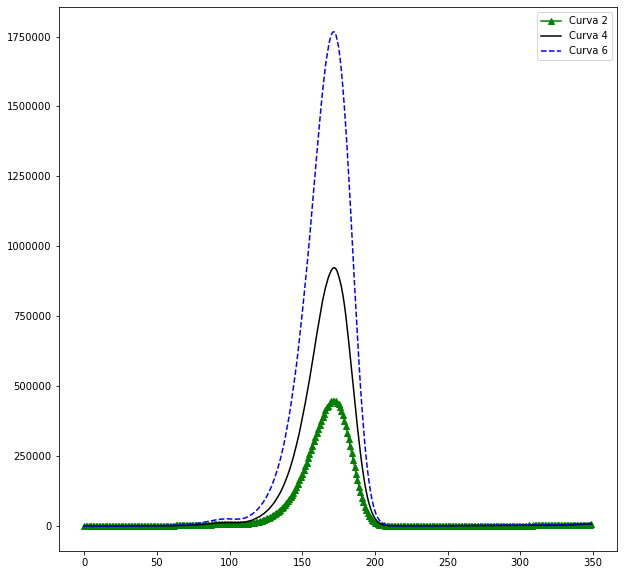

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
i = [2,4,6]
cor = ['^g-','k-','b--']
Fig1=plt.Figure(figsize=(10,10)); ax = Fig1.add_subplot(1,1,1)
for isa,color in zip(i,cor):
    ax.plot(arquivo2.data['Temperatura'], arquivo2.data['Curva {0}'.format(isa)], color, label= 'Curva {0}'.format(isa))
ax.legend(loc='best')
Fig1

# step004.txt

In [16]:
arquivo3=Lumia(pre_heat=True)
arquivo3.load_TL('C:/Users/André Tavares/Desktop/MESTRADO - CDTN/Ensaio Luiz/steps004.txt', lim_init=2)
arquivo3.data = arquivo3.data[:][:350]
arquivo3.data.pop('Curva 1');arquivo3.data.pop('Curva 2');arquivo3.data.pop('Curva 3');arquivo3.data.pop('Curva 4')
heat_rate = [0.5]*2+[1]*2+[2]*2+[3]*2+[4]*2+[5]*2+[6]*2+[7]*2+[8]*2+[9]*2+[10]*2+[20]*2+[0.1]*2
label=['TLD-500','ALOX-520']*13

Faltam informações para se determinar as taxas de aquecimento para 12 taxas de aquecimento seria necessário 24 curvas e tem-se 30

In [17]:
arquivo3.data

,Temperatura,Curva 5,Curva 6,Curva 7,Curva 8,Curva 9,Curva 10,Curva 11,Curva 12,Curva 13,...,Curva 21,Curva 22,Curva 23,Curva 24,Curva 25,Curva 26,Curva 27,Curva 28,Curva 29,Curva 30
0,0,52341,178,47780,73,36787,52,26413,35,20209,...,10050,17,8938,8,7934,9,9,9,20033,449
1,1,50444,153,45696,98,36279,44,26321,25,19980,...,10134,10,8953,17,8086,12,12,12,19264,475
2,2,50570,157,44678,104,35480,57,26122,33,19876,...,10106,10,9002,13,8152,14,14,14,18452,478
3,3,52331,155,43267,86,34760,50,25651,43,19982,...,10058,14,8934,7,8334,5,5,5,17157,500
4,4,55693,128,41445,83,34480,46,26003,30,19907,...,10078,7,8855,7,8082,3,3,3,16189,532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,345,7406,33479,3946,16601,2016,10415,1746,7813,1580,...,1405,4080,1540,3923,1774,3805,3805,3805,36638,54877
346,346,7771,33936,4255,17064,2217,10410,1697,7775,1531,...,1564,4082,1639,4098,1886,4005,4005,4005,38346,56521
347,347,8283,34353,4288,17100,2313,10541,1951,7975,1652,...,1567,4053,1661,4116,2039,4083,4083,4083,41384,59147
348,348,8475,34872,4554,17192,2566,10686,2024,8045,1692,...,1614,4129,1727,4281,1981,4216,4216,4216,43293,61073


In [18]:
ir3=arquivo3.extract_ir()
ir3['detector']=label
ir3['heat_rate'] = heat_rate
ir3

,EA_IR(eV),error_ir,r^2_ir,objeto,detector,heat_rate
Curva 5,1.242207,0.004586,-0.999918,Curva 5,TLD-500,0.5
Curva 6,1.297703,0.003135,-0.999965,Curva 6,ALOX-520,0.5
Curva 7,1.208523,0.007279,-0.999782,Curva 7,TLD-500,1.0
Curva 8,1.335338,0.004984,-0.999916,Curva 8,ALOX-520,1.0
Curva 9,1.200118,0.008742,-0.999682,Curva 9,TLD-500,2.0
Curva 10,1.373481,0.005420,-0.999907,Curva 10,ALOX-520,2.0
Curva 11,1.184937,0.008397,-0.999699,Curva 11,TLD-500,3.0
Curva 12,1.379226,0.005758,-0.999895,Curva 12,ALOX-520,3.0
Curva 13,1.186487,0.006985,-0.999792,Curva 13,TLD-500,4.0
Curva 14,1.375813,0.003881,-0.999952,Curva 14,ALOX-520,4.0


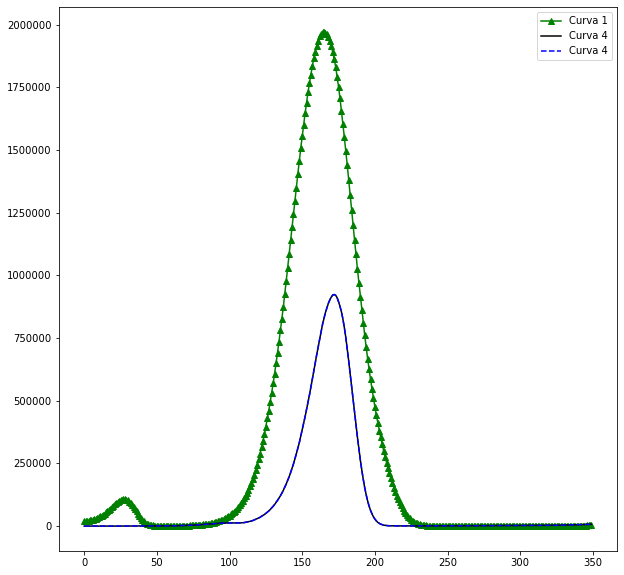

In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
i = [1,4,4]
cor = ['^g-','k-','b--']
Fig1=plt.Figure(figsize=(10,10)); ax = Fig1.add_subplot(1,1,1)
for isa,color in zip(i,cor):
    ax.plot(arquivo2.data['Temperatura'], arquivo2.data['Curva {0}'.format(isa)], color, label= 'Curva {0}'.format(isa))
ax.legend(loc='best')
Fig1

In [19]:
area3 = arquivo3.extract_area(heat_rate, [1.1,1.2,1.3,1.4])
area3['detector']=label
area3['heat_rate'] = heat_rate

In [21]:
import numpy as np
import pandas as pd
chen3 = arquivo3.extract_pshape()
chen3['detector']=label
chen3['heat_rate'] = heat_rate

In [22]:
ir3.to_csv('C:/Users/André Tavares/Desktop/MESTRADO - CDTN/Ensaio Luiz/step004_IR.csv', sep='\t')
chen3.to_csv('C:/Users/André Tavares/Desktop/MESTRADO - CDTN/Ensaio Luiz/step004_CHEN.csv', sep='\t')
area3.to_csv('C:/Users/André Tavares/Desktop/MESTRADO - CDTN/Ensaio Luiz/step004_AREA.csv', sep='\t')

In [23]:
area3

,EA_AREA(eV),error_AREA,r^2_AREA,freq_factor_AREA,ff_err_AREA,ff_percerr_AREA,AREA_kin_order,objeto,Taxa de aquecimento,detector,heat_rate
Curva 5,1.150989,0.013760,-0.994121,1.596795e-12,5.958607e-13,0.373161,b = 1,Curva 5,0.5,TLD-500,0.5
Curva 6,1.342387,0.007924,-0.998557,1.100716e-14,2.365506e-15,0.214906,b = 1,Curva 6,0.5,ALOX-520,0.5
Curva 7,1.109845,0.013901,-0.993168,8.390927e-12,3.110478e-12,0.370695,b = 1,Curva 7,1.0,TLD-500,1.0
Curva 8,1.339486,0.007942,-0.998457,2.340429e-14,4.956877e-15,0.211794,b = 1,Curva 8,1.0,ALOX-520,1.0
Curva 9,1.044479,0.013620,-0.991771,9.069269e-11,3.223347e-11,0.355414,b = 1,Curva 9,2.0,TLD-500,2.0
Curva 10,1.306402,0.009250,-0.997552,1.325916e-13,3.200554e-14,0.241384,b = 1,Curva 10,2.0,ALOX-520,2.0
Curva 11,0.925920,0.020785,-0.980909,2.645519e-09,1.369920e-09,0.517826,b = 1,Curva 11,3.0,TLD-500,3.0
Curva 12,1.333846,0.010151,-0.997749,1.196342e-13,3.025443e-14,0.252891,b = 1,Curva 12,3.0,ALOX-520,3.0
Curva 13,1.000648,0.022093,-0.981514,5.069289e-10,2.790260e-10,0.550424,b = 1,Curva 13,4.0,TLD-500,4.0
Curva 14,1.415300,0.013939,-0.996238,2.486008e-14,8.633300e-15,0.347276,b = 1,Curva 14,4.0,ALOX-520,4.0


In [24]:
chen3

,tau_chen(eV),omega_chen(eV),delta_chen(eV),delta_error,ordem_cinetica,tmax,t1,t2,IM,Shape_factor,Sf_error,objeto,detector,heat_rate
Curva 5,1.188061,1.088102,1.207300,0.036255,Ordem Geral,444,423,462,6743035,0.461538,0.018738,Curva 5,TLD-500,0.5
Curva 6,1.283696,1.107430,1.201607,0.052743,Primeira Ordem,449,431,461,3399429,0.400000,0.023333,Curva 6,ALOX-520,0.5
Curva 7,1.121603,1.031735,1.149070,0.031269,Ordem Geral,452,429,472,4696199,0.465116,0.017036,Curva 7,TLD-500,1.0
Curva 8,1.425480,1.281259,1.412685,0.053551,Primeira Ordem,456,438,470,2652104,0.437500,0.022461,Curva 8,ALOX-520,1.0
Curva 9,1.010948,0.932384,1.049944,0.026135,Ordem Geral,462,436,484,3082868,0.458333,0.015191,Curva 9,TLD-500,2.0
Curva 10,1.383754,1.230957,1.357541,0.051384,Primeira Ordem,468,449,482,2177067,0.424242,0.021579,Curva 10,ALOX-520,2.0
Curva 11,1.034961,0.960987,1.071754,0.023725,Ordem Geral,468,441,493,2361421,0.480769,0.014238,Curva 11,TLD-500,3.0
Curva 12,1.366655,1.221901,1.351861,0.047902,Primeira Ordem,476,456,491,1915037,0.428571,0.020408,Curva 12,ALOX-520,3.0
Curva 13,0.954664,0.886038,1.002963,0.022171,Ordem Geral,475,446,500,1933710,0.462963,0.013546,Curva 13,TLD-500,4.0
Curva 14,1.409124,1.259328,1.391914,0.049279,Primeira Ordem,483,463,498,1724405,0.428571,0.020408,Curva 14,ALOX-520,4.0


In [33]:
ir3

,EA_IR(eV),error_ir,r^2_ir,objeto,detector,heat_rate
Curva 5,1.242207,0.004586,-0.999918,Curva 5,TLD-500,0.5
Curva 6,1.297703,0.003135,-0.999965,Curva 6,ALOX-520,0.5
Curva 7,1.208523,0.007279,-0.999782,Curva 7,TLD-500,1.0
Curva 8,1.335338,0.004984,-0.999916,Curva 8,ALOX-520,1.0
Curva 9,1.200118,0.008742,-0.999682,Curva 9,TLD-500,2.0
Curva 10,1.373481,0.005420,-0.999907,Curva 10,ALOX-520,2.0
Curva 11,1.184937,0.008397,-0.999699,Curva 11,TLD-500,3.0
Curva 12,1.379226,0.005758,-0.999895,Curva 12,ALOX-520,3.0
Curva 13,1.186487,0.006985,-0.999792,Curva 13,TLD-500,4.0
Curva 14,1.375813,0.003881,-0.999952,Curva 14,ALOX-520,4.0
